<a href="https://colab.research.google.com/github/sergekamanzi/Water-Quality-Model/blob/serge_branch/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Nadam Optimizer + Weight Decay(L1) + Gradient Clipping***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_classification
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l1
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load dataset
df = pd.read_csv("/content/water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Handle missing values (impute with median)
df.fillna(df.median(), inplace=True)

In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Split into features (X) and target (Y)
X = df.drop(columns=["Potability"])
Y = df["Potability"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


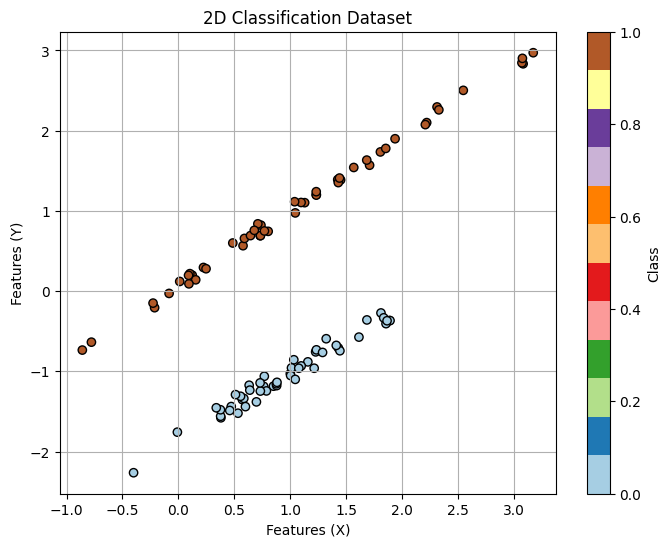

In [ ]:
# Generate 2D classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
plt.title('2D Classification Dataset')
plt.xlabel('Features (X)')
plt.ylabel('Features (Y)')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

In [ ]:
# Nadam Optimizer + Weight Decay + Gradient Clipping
def build_model_2():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l1(0.002), input_shape=(9,)),
        Dropout(0.2),  # Slightly reduced dropout
        Dense(64, activation='relu', kernel_regularizer=l1(0.002)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Nadam(learning_rate=0.001, clipnorm=1.0, weight_decay=0.002)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
%%capture
# Early stopping with slightly lower patience
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
model_2 = build_model_2()
history_2 = model_2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=32,
                        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

In [ ]:
results_2 = model_2.evaluate(X_test, Y_test, verbose=1)
print("Model 2 - Loss: {:.4f}, Accuracy: {:.4f}".format(results_2[0], results_2[1]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900 - loss: 0.6572 
Model 2 - Loss: 0.6613, Accuracy: 0.6850


In [ ]:
# Get model predictions with a lower threshold
y_pred = (model_2.predict(X_test) > 0.4).astype(int)  # Lowered from 0.5 to 0.4

# Compute F1 Score
f1 = f1_score(Y_test, y_pred)
print("Model 2 - F1 Score: {:.4f}".format(f1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model 2 - F1 Score: 0.5849


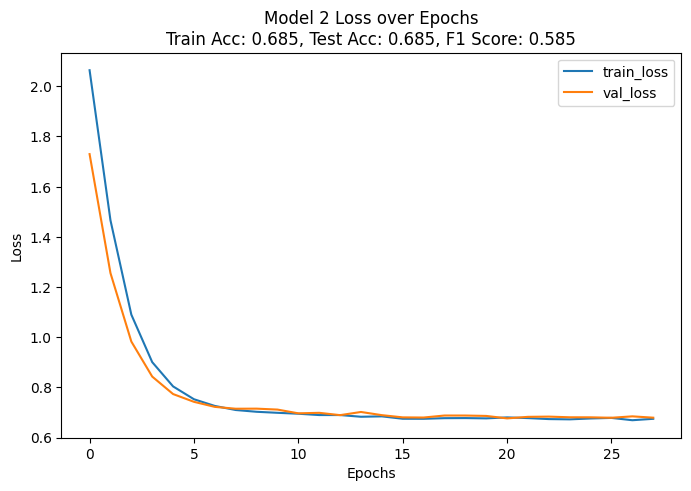

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['val_loss'], label='val_loss')

# Display accuracy & F1 Score in the title
plt.title(f'Model 2 Loss over Epochs\nTrain Acc: {results_2[1]:.3f}, Test Acc: {results_2[1]:.3f}, F1 Score: {f1:.3f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**2 reasons for my techniques**

*** Adam Optimizer + Batch Normalization + Lower Dropout***,

1.Adam is a reliable and widely-used optimizer for classification tasks

2.Adam generally is faster, which is important when you're working with complex data


***SGD Optimizer + L2 Regularization + Dropout (Moderate)***

1.Mine is beneficial because these dataset has a lot of missing data and it can handle them.

2.SGD might be better suited for a smaller classification task

**TABLE**

In [ ]:
data = {
    'Train Instance': ['70%'],
    'Engineer Name': ['KAMANZI Serge'],
    'Regularizer': ['L1'],
    'Optimizer': ['Nadam'],
    'Early Stopping': ['Yes'],
    'Dropout Rate': ["20%"],
    'Accuracy': [0.6850],
    'F1 Score': [0.5849],
    'Recall': ["Depends on F1 and Precision"],
    'Precision': ["Depends on F1 and Recall"]
}

table = pd.DataFrame(data)

table

,Train Instance,Engineer Name,Regularizer,Optimizer,Early Stopping,Dropout Rate,Accuracy,F1 Score,Recall,Precision
0,70%,KAMANZI Serge,L1,Nadam,Yes,20%,0.685,0.5849,Depends on F1 and Precision,Depends on F1 and Recall
